In [1]:
import tensorflow
from tensorflow import keras

2022-10-04 08:57:09.982812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy
import os 
import cv2
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import backend as K
import random
import pickle



In [3]:

import os
from pathlib import Path
root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"


In [4]:
classes = ['Apple___Apple_scab','Apple___healthy']
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

Apple___Apple_scab
Apple___healthy


In [5]:

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = load_img(img_path, target_size=(120, 120))
img_data = img_to_array(img, dtype = int)
img_data = np.expand_dims(img_data, axis=0)

File path: /Users/jonaspedersen/Dokumenter/Visual_rec/project/data_test/plantvillage/Apple___Apple_scab/bceb695a-e877-4b2b-bf05-241661d511d4___FREC_Scab 3240.JPG


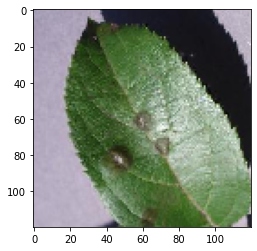

In [6]:
from cgitb import grey

plt.imshow(img_data[0])

In [7]:
np.min(img_data[0])

0

In [8]:
def getPermutation(image_array, tilenumberx=3, shuffle = True):
    """Takes an image as an array, and returns a permuted image as an array
    with corresponding labels.
    """
    idx = range(tilenumberx**2)
    if shuffle:
        idx = np.random.permutation(tilenumberx**2)
    tilesize_h = image_array.shape[0]//(tilenumberx)
    tilesize_w = image_array.shape[1]//(tilenumberx)
    #if len(image_array.shape) == 4:
    #    tiles = [np.array([image[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx])for image in image_array]
    #else:
    #    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    out = np.array(tiles)
    

    return out, idx

In [9]:
for image in img_data:
    X, y = getPermutation(image, shuffle=False)
    print(X.shape)


(9, 40, 40, 3)


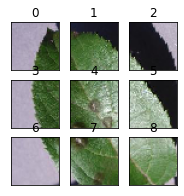

In [10]:
X, y = getPermutation(img_data[0], shuffle=False)
plt.figure(figsize=(3,3))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i])
    plt.xticks([]), plt.yticks([])
    plt.title(int(y[i]))

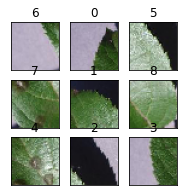

In [13]:
X, y = getPermutation(img_data[0])
plt.figure(figsize=(3,3))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i])
    plt.xticks([]), plt.yticks([])
    plt.title(int(y[i]))

In [ ]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class PermNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = self.images.shape[0]

        super(PermNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(len(index_array), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
          
            image = self.images[j].squeeze()

            # get a random angle
            rotation_angle = np.random.randint(-30,30)

            # rotate the image
            rows,cols = image.shape
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),rotation_angle,1)
            rotated_image = cv2.warpAffine(image,M,(cols,rows))

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i], batch_y[i] = getPermutation(image)

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)


NameError: name 'train_x' is not defined

In [ ]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

2022-10-02 20:35:55.247496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
gen_path = p
train_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
N = 4
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

In [ ]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [ ]:
from keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5


/var/folders/l9/9d49h4t14s52dq6c276zwhgc0000gn/T/ipykernel_39250/2694328886.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


317/317 [==============================] - 45s 132ms/step - loss: 0.1839 - accuracy: 0.8770 - val_loss: 0.0905 - val_accuracy: 0.9636
Epoch 2/5
317/317 [==============================] - 42s 133ms/step - loss: 0.0751 - accuracy: 0.9644 - val_loss: 0.0651 - val_accuracy: 0.9715
Epoch 3/5
317/317 [==============================] - 45s 142ms/step - loss: 0.0528 - accuracy: 0.9786 - val_loss: 0.0546 - val_accuracy: 0.9810
Epoch 4/5
317/317 [==============================] - 50s 156ms/step - loss: 0.0419 - accuracy: 0.9870 - val_loss: 0.0519 - val_accuracy: 0.9826
Epoch 5/5
317/317 [==============================] - 46s 145ms/step - loss: 0.0345 - accuracy: 0.9881 - val_loss: 0.0481 - val_accuracy: 0.9826


In [ ]:
model.save("models/2022_09_29__01")

INFO:tensorflow:Assets written to: models/29sep_01/assets


INFO:tensorflow:Assets written to: models/29sep_01/assets
